In [2]:
import numpy as np
import gym
import gym_bandits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def run_simulation(get_action, env, m=2, num_trials=2000):
    '''Runs a m-armed bandit simulation for multiple trials.
    Args:
    - get_action: a function which has input (t, means, count) and returns action
    - num_trials: number of iterations
    - m: number of bandits
    Returns:
    - A list of regret versus time 
    '''
    parameters = {}
    parameters['means']=np.zeros(m)
    parameters['count']=np.zeros(m)
    parameters['theta']=np.zeros(m) # parameters for policy gradient
    alpha=0.1 # learning rate for policy gradient
    choices = []
    
    for t in range(num_trials):

        action = get_action(t, parameters)
        observation, reward, done, info = env.step(action)

        # Keep track of sample means for exploitation, and choices for regret calculation 
        parameters['count'][action] += 1
        parameters['means'][action] = (1 - 1/parameters['count'][action]) * parameters['means'][action] + (1/parameters['count'][action]) * reward
        ind = np.ones((m,), bool)
        ind[action] = False
        ps = np.exp(parameters['theta'])/np.sum(np.exp(parameters['theta'])) # softmax
        parameters['theta'][action] = parameters['theta'][action]+alpha*reward*(1-ps[action]) # update gradients
        parameters['theta'][ind] = parameters['theta'][ind]-alpha*reward*ps[ind]
        choices.append(action)

    def regret(t):
        best = np.argmax(parameters['means'])
        return parameters['means'][best] * t - sum([parameters['means'][choices[i]] for i in range(t)])

    return [regret(t) for t in range(num_trials)]


def epsilon_greedy_action(t, parameters, epsilon=0.5):
    '''epsilon percent of the time, choose a random action.
    (1-epsilon) percent of the time, exploit by choosing the action
    with the highest mean reward.
    
    This is a suboptimal solution, achieving linear regret. 
    '''
    explore = np.random.uniform() < epsilon

    if explore:
        return env.action_space.sample()
    else:
        return np.argmax(parameters['means'])


def upper_confidence_bounds_action(t, parameters, epsilon=0.0):
    '''Play each arm once, then choose according to the equation given
    by Auer, Cesa-Bianchi & Fisher (2002).
    
    This is said to achieve the most optimal solution, with logarithmic regret.
    '''
    if t < len(parameters['means']):
        return t
    else:
        return np.argmax(parameters['means'] + np.sqrt(2 * np.log(t)/parameters['count']))
    
def policy_gradient_action(t, parameters):
    '''Play each arm according to the policy function determined by the softmax.
    '''
    ps = np.exp(parameters['theta'])/np.sum(np.exp(parameters['theta'])) # softmax
    
    return np.random.choice(np.arange(len(ps)), p=ps)

## Two-arm bandit:
p_dist: Probability Distributions - A list of probabilities of the likelihood that a particular bandit will pay out

r_dist: Reward Distributions - A list of either rewards (if number) or means and standard deviations (if list) of the payout that bandit has

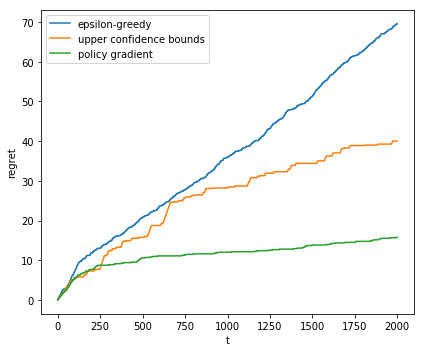

In [18]:
env = gym.make('BanditEnv-v0') # 'BanditTenArmedGaussian-v0'
#p1=0.8, p2=0.9, mean_r1=1, std_r1=2, mean_r2=1, std_r2=0.2
p_dist=[0.8,0.9]
r_dist=[[1,0.1], [1,0.1]]
env.env.__init__(p_dist=p_dist, r_dist=r_dist) 
env.reset()
env.seed(9)

'''Compares the epsilon-greedy approach, the upper confidence bounds and policy gradient
approach for solving the multi-armed bandit problem.'''
results_eps = run_simulation(epsilon_greedy_action, env,m=len(p_dist), num_trials=2000)
results_ucb = run_simulation(upper_confidence_bounds_action, env,m=len(p_dist), num_trials=2000)
results_pyg = run_simulation(policy_gradient_action, env,m=len(p_dist), num_trials=2000)
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
ax.plot(results_eps,  label='epsilon-greedy')
ax.plot(results_ucb,  label='upper confidence bounds')
ax.plot(results_pyg,  label='policy gradient')
ax.set_xlabel('t')
ax.set_ylabel('regret')
ax.legend()
fig.tight_layout()
fig_name='2arm_bandit'+'.pdf'
fig.savefig(fig_name, dpi=300, transparent=True)
plt.show()

## Ten-arm bandit:

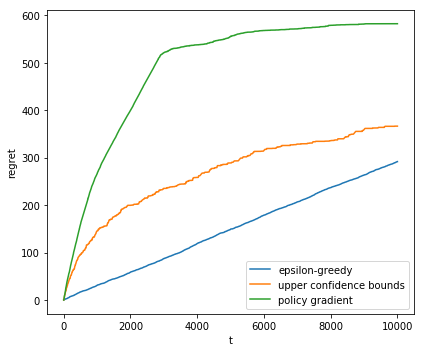

In [22]:
env = gym.make('BanditEnv-v0') # 'BanditTenArmedGaussian-v0'
#p1=0.8, p2=0.9, mean_r1=1, std_r1=2, mean_r2=1, std_r2=0.2
p_dist=[0.9, 0.8, 0.7, 0.65, 0.6,0.5, 0.4,0.3, 0.2, 0.1]
r_dist=[1, 1, 1 ,1 ,1, 1, 1, 1, 1, 1]
env.env.__init__(p_dist=p_dist, r_dist=r_dist) 
env.reset()
env.seed(9)

'''Compares the epsilon-greedy approach, the upper confidence bounds and policy gradient
approach for solving the multi-armed bandit problem.'''
results_eps = run_simulation(epsilon_greedy_action, env,m=len(p_dist), num_trials=10000)
results_ucb = run_simulation(upper_confidence_bounds_action, env,m=len(p_dist), num_trials=10000)
results_pyg = run_simulation(policy_gradient_action, env,m=len(p_dist), num_trials=10000)
fig, ax = plt.subplots()
fig.set_size_inches(6, 5)
ax.plot(results_eps,  label='epsilon-greedy')
ax.plot(results_ucb,  label='upper confidence bounds')
ax.plot(results_pyg,  label='policy gradient')
ax.set_xlabel('t')
ax.set_ylabel('regret')
ax.legend()
fig.tight_layout()
fig_name='10arm_bandit'+'.pdf'
fig.savefig(fig_name, dpi=300, transparent=True)
plt.show()